# How to use this script

This script is used in AWS Sagemaker to build and deploy machine learning models

In [1]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import pandas as pd


In [2]:
#%%writefile preprocessing.py

import argparse
import os
import warnings

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

In [106]:
bucket='sagemaker-us-east-2-681954894216'

path = 'data/dataset.csv'

s3uri = 's3://{}/{}'.format(bucket, path)

df = pd.read_csv(s3uri, sep=';')

In [107]:
df.sample(5)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
9394,11fd8dd8-2587-4576-bb0b-0166a62f8ad9,0.0,23890,0.0,0.0,0.0,0.577640,1.0,1.0,1.0,...,1,1,1,1,0,18254,10420,197763,19.096944,NaN
23722,e3cd5bc2-4e73-43b0-9c88-4332cec75104,0.0,5872,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,...,0,2,2,2,0,11582,5854,16669,16.126389,1.0
35822,bc7cbe58-e10e-424a-a735-3a602a1bdb55,0.0,0,0.0,0.0,0.0,61.176056,1.0,1.0,NaN,...,1,2,2,2,0,0,0,133098,21.653889,1.0
36675,f608d4c6-544d-4a7b-aee8-e66b808ae264,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,38825,18.415833,NaN
79848,e81b68f2-071f-4713-9ce1-f66bc74cf36f,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,NaN,...,1,1,1,1,0,5642,0,85969,6.741111,1.0


## Data Preprocessing

In [108]:
cat_cols = ['account_status', 
        'account_worst_status_0_3m', 
        'account_worst_status_12_24m', 
           'account_worst_status_3_6m', 
        'account_worst_status_6_12m', 
        'worst_status_active_inv',
        'status_last_archived_0_24m', 
        'status_2nd_last_archived_0_24m', 
        'status_3rd_last_archived_0_24m',
        'status_max_archived_0_6_months', 
        'status_max_archived_0_12_months', 
        'status_max_archived_0_24_months',
        'has_paid',
        'name_in_email', 
        'merchant_group',
        'merchant_category',
        'uuid']
# for c in cat_cols:
#     df[c]= df[c].values.astype(str)
cat_features = cat_cols[:-1]
num_features= [col for col in df.columns.tolist() if col not in (cat_cols)]
label = ['default']
num_features = num_features[1:]

    # Removing highly correlated features
highly_corelated_features = ['max_paid_inv_0_12m',
                             'avg_payment_span_0_3m',
                             'sum_capital_paid_account_12_24m', 
                             'num_arch_ok_0_12m']

df = df.drop(highly_corelated_features, axis=1)

num_features=[col for col in num_features if col not in highly_corelated_features]

## Missing Data Imputation 1 
### for some columns, the median of default = 1 is higher than default = 0, hence, I impute the missing data with median grouping by the category
feature_higher_1 = ['avg_payment_span_0_12m',
                    'account_days_in_rem_12_24m',
                    'num_active_div_by_paid_inv_0_12m' ]

na_cols = ['account_days_in_dc_12_24m',
 'account_days_in_term_12_24m',
 'account_incoming_debt_vs_paid_0_24m',
 'num_arch_written_off_0_12m',
 'num_arch_written_off_12_24m']

for c in feature_higher_1:
    df[c] = df[df['default'] != 'nan'][c].transform(lambda x: x.fillna(x.median()))

for c in na_cols:
    df[c] = df[df['default'] != 'nan'][c].transform(lambda x: x.fillna(x.median()))

# Label encoding for ordinal categorical features
#label encoding better for ordinal data with high cardinality
#one hot encoding better for low cardinality and not ordinal data

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler

labelencoder = LabelEncoder()
for feat in cat_features[0:11]:
    df[feat] = labelencoder.fit_transform(df[feat].astype(str))


#Binary encoding for Boolean columns
dict1 = {True: 0, False:1}
var = 'has_paid'
df[var+'_ordinal'] = df['has_paid'].map(dict1)
df = df.drop(var, axis=1)


scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

for c in cat_features[13:]:
    dummies = pd.get_dummies(df[c])
    df[dummies.columns] = dummies

df = df.drop(cat_features[13:], axis=1)

#find missing values

In [134]:
df_train = df[df['default'].notnull()]
df_test = df[df['default'].isnull()]

In [135]:
y = df_train['default']
X = df_train.drop(['uuid', 'default'],axis = 1)

cat_features[-4]= 'has_paid_ordinal'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y)
from sklearn.linear_model import LinearRegression
regressor = LogisticRegression(max_iter=10000)
regressor.fit(X_train, y_train)

# Print the coefficients of the trained classifier, and save the coefficients
#joblib.dump(regressor, os.path.join(args.model_dir, "model.joblib"))

LogisticRegression(max_iter=10000)

In [136]:
#X_train

In [137]:
test_data = df_test.drop(['uuid', 'default'],axis = 1)

In [77]:
# def model_fn(model_dir):
#     """Deserialized and return fitted model
    
#     Note that this should have the same name as the serialized model in the main method
#     """
#     regressor = joblib.load(os.path.join(model_dir, "model.joblib"))
#     return regressor

## Prediction on the test sets

In [138]:
yhat = regressor.predict(X_test)
yhat_prob = regressor.predict_proba(X_test)

In [139]:
yhat

array([0., 0., 0., ..., 0., 0., 0.])

In [140]:
yhat_prob[:,1]

array([0.00168492, 0.01501433, 0.00267852, ..., 0.00428344, 0.01084724,
       0.00309548])

## Prediction on the unknown labels 

In [116]:
yhat_test = regressor.predict(test_data)
yhat_prob_test = regressor.predict_proba(test_data)

In [117]:
df_pred = pd.DataFrame({'uuid':df_test['uuid'], 'y':yhat_prob_test[:,1]})
df_pred.to_csv('final_prediction_result.csv')

In [118]:
df_pred

,uuid,y
89976,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.012359
89977,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.011938
89978,e9c39869-1bc5-4375-b627-a2df70b445ea,0.006468
89979,6beb88a3-9641-4381-beb6-c9a208664dd0,0.008778
89980,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.060918
...,...,...
99971,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,0.019608
99972,f8db22f4-9819-420c-abbc-9ddf1843176e,0.011805
99973,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,0.019273
99974,bafcab15-9898-479c-b729-c9dda7edb78f,0.019738


# Evaluating Model Performances
## Initial model performances on the hold out test set

In [119]:
print("model score: %.3f" % regressor.score(X_test, y_test))

model score: 0.985


In [30]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [32]:
# y_train_pred = regressor.predict(X_train)
# y_train_proba = regressor.predict_proba(X_train)

In [147]:
print('Acc:', accuracy_score( y_test, yhat))
print('F1:', f1_score(y_test, yhat))
print('ROC AUC:', roc_auc_score(y_test, yhat_prob[:,1]))

Acc: 0.9854412091575906
F1: 0.03676470588235294
ROC AUC: 0.8608883743655499


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17738
         1.0       0.36      0.02      0.04       258

    accuracy                           0.99     17996
   macro avg       0.67      0.51      0.51     17996
weighted avg       0.98      0.99      0.98     17996




## Cross validated ACC, FI, ROC AUC scores

In [61]:
print('Acc:', cross_val_score(regressor, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(regressor, X, y, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(regressor, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.9853627631493055
F1: 0.04907389655467488
ROC AUC: 0.8652299978494721


In [85]:
type(y_test)

pandas.core.series.Series

In [92]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yhat))

[[17729     9]
 [  253     5]]


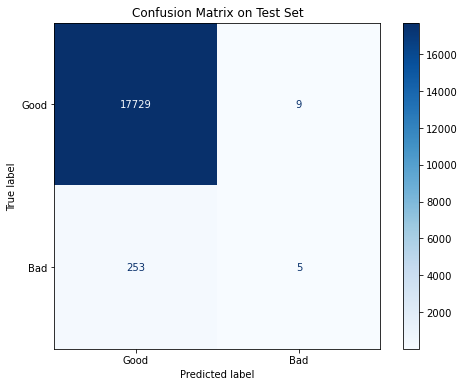

In [150]:
import matplotlib.pyplot as plt
# Confusion matrix

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(regressor, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set')
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.13')

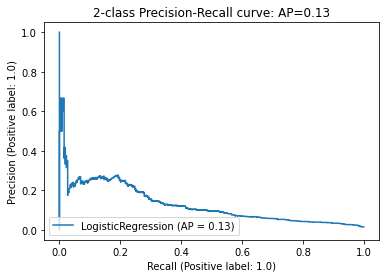

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
# y_score = regressor.decision_function(X_test)
y_score = regressor.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

disp = plot_precision_recall_curve(regressor, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

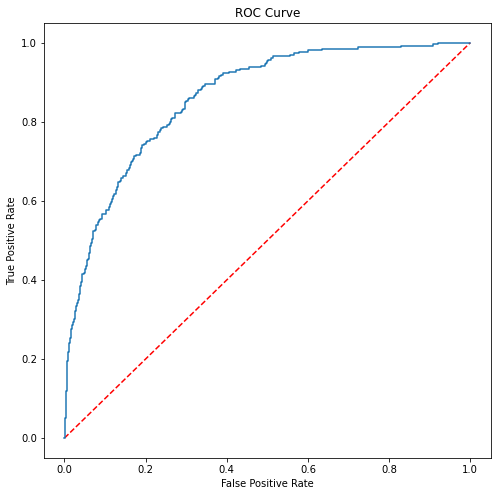

In [99]:
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(8, 8))
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds= roc_curve(y_test, yhat_prob[:,1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [43]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# import matplotlib.pyplot as plt
# logit_roc_auc = roc_auc_score(y_test, regressor.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, regressor.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

## Hyperparameter Tuning

logistic regression also has a regularization parameter: C.C controls the inverse of the regularization strength. A large C can lead to an overfit model, while a small C can lead to an underfit model.

In [49]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

In [100]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

In [120]:
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(regressor, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])})

In [121]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.9856850718146065


# Refit the model using Best parameters

In [151]:
regressor2= LogisticRegression(max_iter=10000, C =logreg_cv.best_params_['C'] )
regressor2.fit(X_train, y_train)
yhat2 = regressor2.predict(X_test)
y_hat_proba2 = regressor2.predict_proba(X_test)

In [155]:
print('Acc:', accuracy_score( y_test, yhat2))
print('F1:', f1_score(y_test, yhat2))
print('ROC AUC:', roc_auc_score(y_test, y_hat_proba2[:,1]))

# Feature Importance

Top 5 features:
- Average payment span for past 0-12 months
- num_arch_dc_0_12m
- number of active
- number of unpaid bills

In [57]:

df_importance = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': regressor.coef_[0]})


In [58]:
df_importance.sort_values('importance', ascending=False)

,feature,importance
11,avg_payment_span_0_12m,6.055580
15,num_arch_dc_0_12m,4.297776
13,num_active_div_by_paid_inv_0_12m,3.557319
16,num_arch_dc_12_24m,3.463677
21,num_unpaid_bills,2.620754
...,...,...
29,sum_capital_paid_account_0_12m,-1.514837
10,age,-1.872435
30,sum_paid_inv_0_12m,-2.797278
12,max_paid_inv_0_24m,-3.682886
